** *
# Microsoft Malware Classification Challenge (BIG 2015)

---


https://www.kaggle.com/c/malware-classification/


>[Microsoft Malware Classification Challenge (BIG 2015)](#scrollTo=zMYQUkNl3e3I)

>[Initial Setup](#scrollTo=U0PO6PE-0JFr)

>>[Download Dataset](#scrollTo=afqc3ABYzOTC)

>[Extract Features](#scrollTo=ms9rLqS_pgRl)



# Initial Setup

## Download Dataset

In [0]:
!pip install kaggle

In [95]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

if not os.path.exists('data/'):

    auth.authenticate_user()

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/content/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)

    !kaggle competitions download -c malware-classification -p data/
    
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [0]:
import re
import glob
from tqdm import tqdm
#from tqdm import tqdm_notebook


import numpy as np
import pandas as pd

import multiprocessing
from multiprocessing.dummy import Pool

In [97]:
cpu_count  = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 3


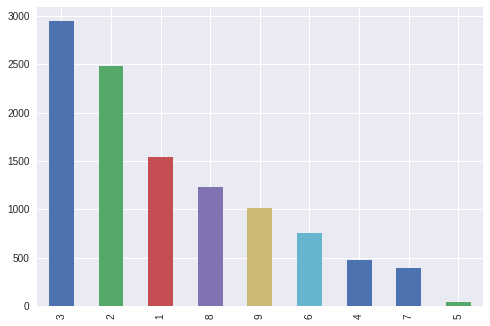

In [98]:
trainLabels = pd.read_csv('data/trainLabels.csv')
trainLabels.Class.value_counts().plot(kind = 'bar')

In [0]:
!cd data && p7zip -d train.7z

# Extract Features

In [0]:
def getOpcodes(file2path):

    openfile = io.open(file2path,'r',encoding='latin-1')
    lines=openfile.readlines()

    opcodes_lst = []

    for line in lines:
        opcode_group = re.search('\s\s\s[a-z][a-z]+\s\s\s',line)
        if opcode_group:
            opcode = opcode_group.group().strip()
            opcodes_lst.append(opcode)
            pass
            
    return opcodes_lst, file2path

In [0]:
def extractInParallel(path_lst, threads=2):
    p = Pool(threads)
    opcodes_lst = []
    file_lst = []
    for opcode, file in tqdm((p.imap_unordered(getOpcodes, path_lst)), total=len(path_lst)):
        opcodes_lst.append(opcode)
        file_lst.append(file)
        pass
    p.close()
    p.join()
    return opcodes_lst, file_lst

In [0]:
def extractFeatures(path2data, format_file = '*.asm'):
  
    for subdir, dirs, files in os.walk(path2data):
          print('Reading files from dir: {}'.format(subdir))
          path_folder = os.path.join(subdir, format_file)
          filesPath = glob.glob(path_folder) 
          print('Extractig features from: {} files'.format(len(filesPath)))
          opcodes_lst, file_lst =  extractInParallel(filesPath, threads=cpu_count)
          print('\nDone!')
    return np.array(opcodes_lst), np.array(file_lst)

In [0]:
path2train = 'data/train'
X_train, y_train = extractFeatures(path2train)

In [64]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))

X_train shape: (72,)
y_train shape: (72,)


In [0]:
df = pd.DataFrame(list(X_train))

In [85]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,676962,676963,676964,676965,676966,676967,676968,676969,676970,676971
0,mov,push,push,push,push,call,pop,lea,push,call,...,None,None,None,None,None,None,None,None,None,None
1,push,mov,sub,mov,mov,mov,movzx,mov,movzx,sub,...,None,None,None,None,None,None,None,None,None,None
2,jmp,jmp,fadd,add,sub,sar,push,and,jmp,jmp,...,None,None,None,None,None,None,None,None,None,None
3,mov,jmp,push,mov,mov,call,test,jz,push,call,...,None,None,None,None,None,None,None,None,None,None
4,push,mov,sub,mov,mov,cmp,jz,mov,mov,mov,...,None,None,None,None,None,None,None,None,None,None


In [0]:
import matplotlib.pyplot as plt

Text(0.5,0,'#ocorrences')

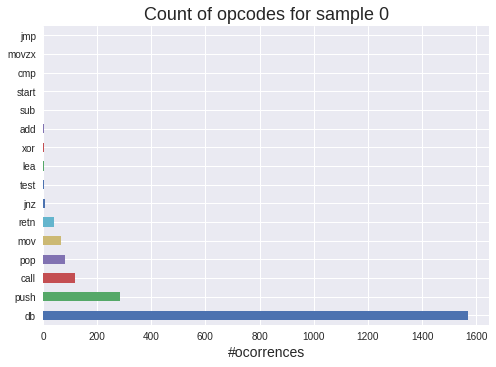

In [93]:
idx = 0

df.iloc[idx].value_counts().plot(kind = 'barh')
plt.title('Count of opcodes for sample {}'.format(idx), fontsize=18)
plt.xlabel('#ocorrences', fontsize=14)

## Saving processed data

In [0]:
def save_data(X, y, file, path2save):

    os.makedirs(path2save)
    
    data ={'X':X, 'y':y}
    np.savez(path2save + file + ".npz",**data)

    print('Saved in: {}'.format(path2save))  

In [74]:
path2saveTrain = 'proc_data/train/'

if not os.path.exists(path2saveTrain):
    save_data(X_train, y_train,'opcodes', path2saveTrain)

else:
    print('Data already processed!')

Saved in: proc_data/train/


# N-grams

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [81]:
max_gram = 4
print('Max_grams: {}'.format(max_gram))

Max_grams: 4


In [82]:
print('Counting ocorrences of words. Ngram-range: {}...'.format(str((1,max_gram))))
vectorizer = CountVectorizer(analyzer = "word",
                             max_features = 300, ngram_range=(1,max_gram)) 
f_train = vectorizer.fit_transform([" ".join(x) for x in X_train])

#downscale weights for words using tf–idf: “Term Frequency times Inverse Document Frequency”.
print('Words downscaling using TF-IDF...')

tfidf_transformer = TfidfTransformer()
f_train = tfidf_transformer.fit_transform(f_train)

model = vectorizer

Counting ocorrences of words. Ngram-range: (1, 4)...
Words downscaling using TF-IDF...
